In [1]:
import numpy as np
import tensorflow as tf
import time
import datetime
import aimBotEnv

from GAIL import GAIL
from GAILConfig import GAILConfig
from PPOConfig import PPOConfig
from GAILMem import GAILMem
from GAILHistory import GAILHistory
from IPython.display import clear_output
from tqdm.notebook import tqdm as tqdm

In [2]:
# Attempts to allocate only the GPU memory needed for allocation
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.random.set_seed(9331)

In [3]:
ENV_PATH = "./Build-CloseEnemyCut/Aimbot-PPO"
EXPERT_DIR = "GAIL-Expert-Data/1015-0148/pack-53518.npz"
WORKER_ID = 1
BASE_PORT = 200
MAX_BUFFER_SIZE = 256

MAX_EP = 1000000000
STACKSTATESSIZE = 3
STACKINTERCE = 29

env = aimBotEnv.makeEnv(
    envPath=ENV_PATH,
    workerID=WORKER_ID,
    basePort=BASE_PORT,
    stackSize=STACKSTATESSIZE,
    stackIntercal=STACKINTERCE,
)

STATE_SIZE = env.STATE_SIZE
DISACT_SHAPE = env.DISCRETE_SHAPE
CONACT_SIZE = env.CONTINUOUS_SIZE
CONACT_RANGE = 10

ppoConf = PPOConfig(
    NNShape=[512, 512, 256],
    actorLR=2e-3,
    criticLR=2e-3,
    gamma=0.99,
    lmbda=0.95,
    clipRange=0.20,
    entropyWeight=5e-3,
    trainEpochs=5,
    saveDir="GAIL-Model/" + datetime.datetime.now().strftime("%m%d-%H%M") + "/",
    loadModelDir=None,
)
gailConf = GAILConfig(
    discrimNNShape=[256, 128],
    discrimLR=1e-4,
    discrimTrainEpochs=5,
    discrimSaveDir="GAIL-Model/" + datetime.datetime.now().strftime("%m%d-%H%M") + "/",
    ppoConfig=ppoConf
)

agentMem = GAILMem()
expertMem = GAILMem()
expertMem.loadMemFile(EXPERT_DIR)
gailHis = GAILHistory()
gail = GAIL(
    stateSize=STATE_SIZE,
    disActShape=DISACT_SHAPE,
    conActSize=CONACT_SIZE,
    conActRange=CONACT_RANGE,
    gailConfig=gailConf,
)


√√√√√Enviroment Initialized Success√√√√√
√√√√√Buffer Initialized Success√√√√√
√√√√√Buffer Initialized Success√√√√√
---------thisPPO Params---------
self.stateSize =  93
self.disActShape =  [3, 3, 2]
self.disActSize 3
self.disOutputSize 8
self.conActSize =  1
self.conActRange =  10
self.conOutputSize =  2
---------thisPPO config---------
self.NNShape =  [512, 512, 256]
self.criticLR =  0.002
self.actorLR =  0.002
self.gamma =  0.99
self.lmbda =  0.95
self.clipRange =  0.2
self.entropyWeight =  0.005
self.trainEpochs =  5
self.saveDir =  GAIL-Model/1020-0318/
self.loadModelDir =  None
---------Actor Model Create Success---------
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stateInput (InputLayer)        [(None, 93)]         0           []                               
                                                   

20777.3


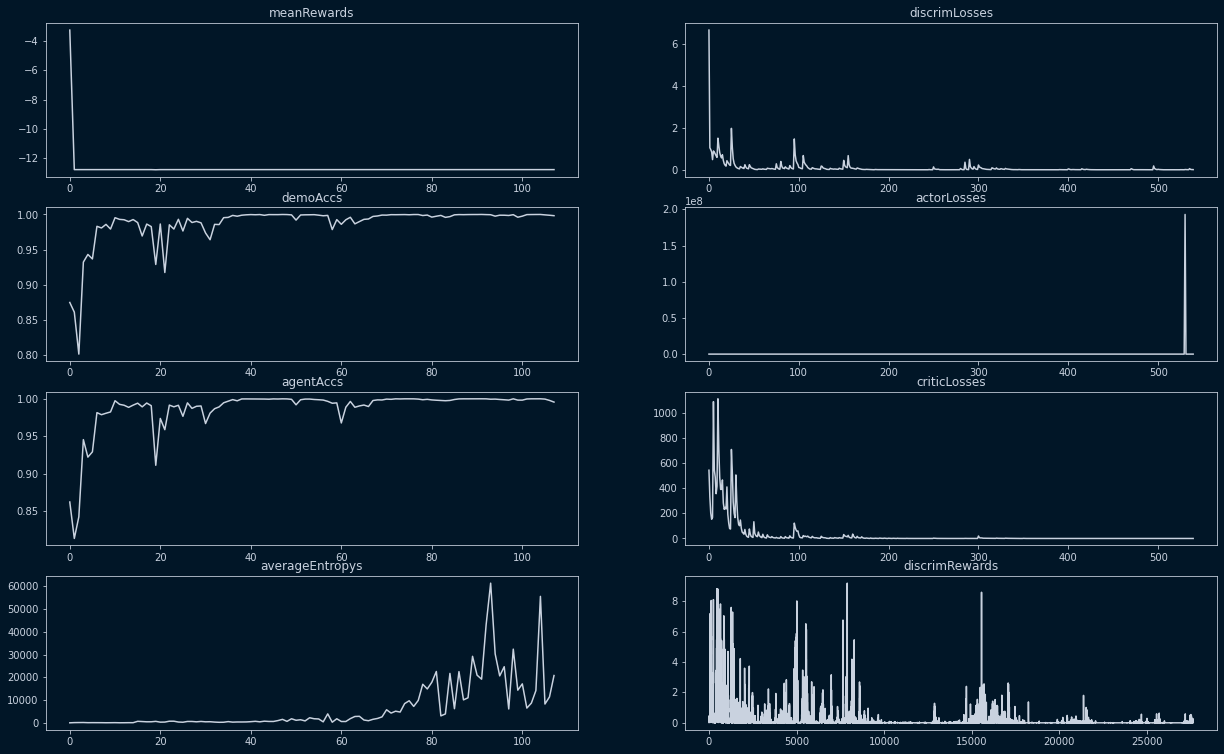

  0%|          | 0/256 [00:00<?, ?it/s]

In [4]:
bestReward = 0
for ep in range(MAX_EP):
    # get sample
    state, _, _, _, _ = env.reset()
    totalRewards = []
    totalReward = 0
    saveNow = 0
    for step in tqdm(range(MAX_BUFFER_SIZE)):
        actions, predictResult = gail.getActions(state)
        nextState, reward, done, _, saveNow = env.step(actions)
        agentMem.saveMems(
            state=state, actorProb=predictResult, action=actions, reward=reward, done=done
        )
        state = nextState
        totalReward += reward
        if done:
            totalRewards.append(totalReward)
            totalReward = 0
            state, _, _, _, _ = env.reset()
    # add reward to history
    totalRewards.append(totalReward)
    # get all memory data
    demoStates, _, demoActions, _, _ = expertMem.getRandomSample(MAX_BUFFER_SIZE)
    agentStates = agentMem.getStates()
    agentActions = agentMem.getActions()
    agentActorProbs = agentMem.getActorProbs()
    agentDones = agentMem.getDones()
    # train discriminatorQ
    discrimLosses, demoAcc, agentAcc = gail.trainDiscriminator(
        demoStates, demoActions, agentStates, agentActions
    )
    # get disriminator predict rewards
    discrimRewards = gail.inference(agentStates, agentActions) * 10.0
    # train agentPPO
    actorLosses, criticLosses, averageEntropy, discreteEntropys, continuousEntropys = gail.trainPPO(
        agentStates, agentActorProbs, agentActions, discrimRewards, agentDones, nextState
    )
    gailHis.saveHis(
        np.mean(totalRewards),
        discrimLosses,
        actorLosses,
        criticLosses,
        demoAcc,
        agentAcc,
        averageEntropy,
        discrimRewards,
    )
    clear_output()
    gailHis.drawHis()
    # got best reward?
    if np.mean(totalRewards) >= bestReward:
        bestReward = np.mean(totalRewards)
        gail.saveWeights(np.mean(totalRewards))
    agentMem.clearMem()
